**Chapter 8 – Dimensionality Reduction**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## Principal Components

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## Projecting Down to d Dimensions

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

## Using Scikit-Learn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [13]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

## Explained Variance Ratio

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [20]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [21]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


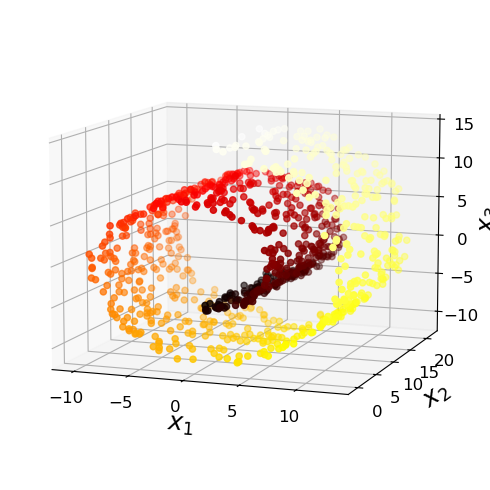

In [22]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Saving figure squished_swiss_roll_plot


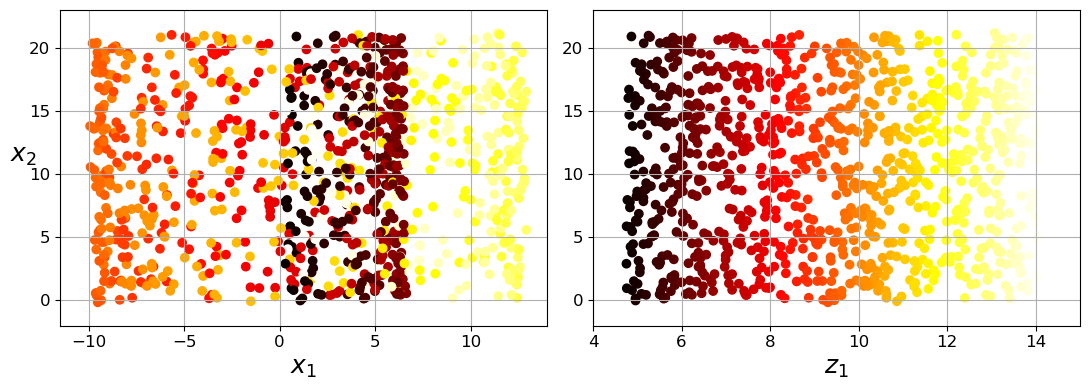

In [23]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Saving figure manifold_decision_boundary_plot1


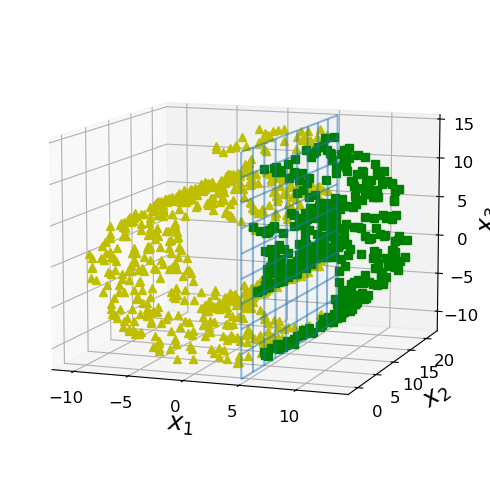

Saving figure manifold_decision_boundary_plot2


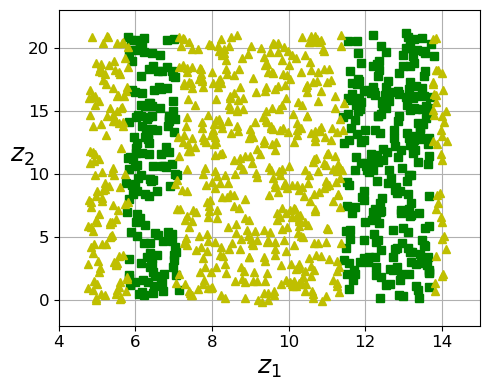

Saving figure manifold_decision_boundary_plot3


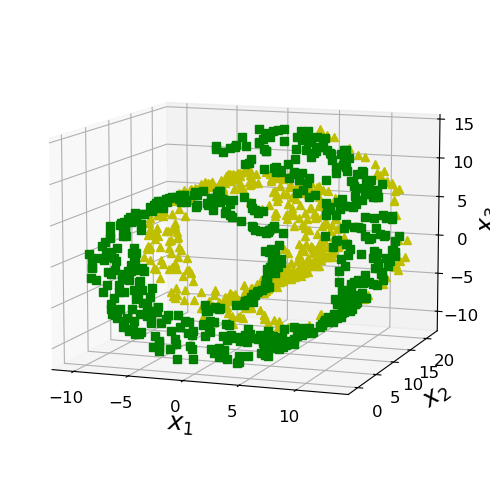

Saving figure manifold_decision_boundary_plot4


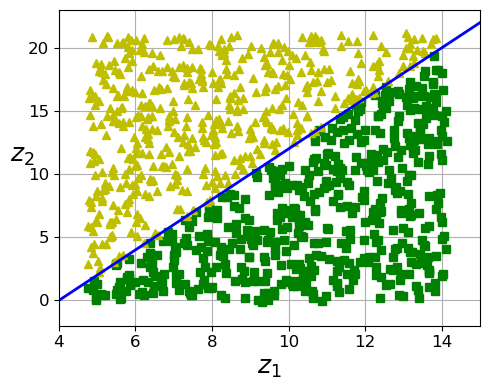

In [24]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

Saving figure pca_best_projection_plot


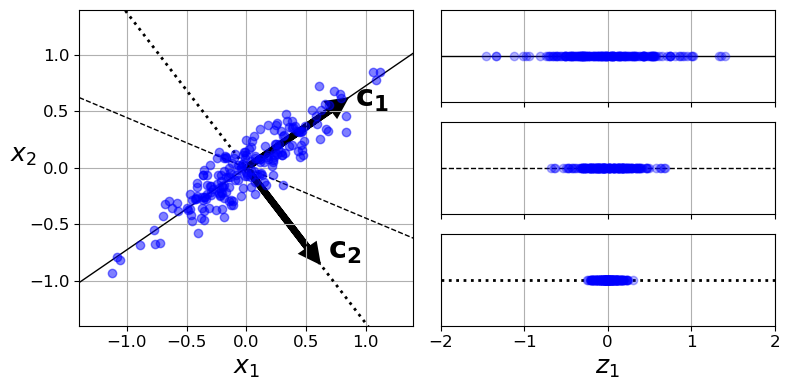

In [25]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

## Choosing the Right Number of Dimensions

In [26]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [27]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [29]:
d

154

Saving figure explained_variance_plot


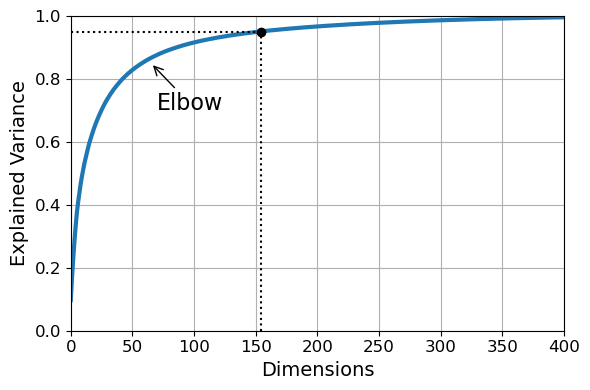

In [30]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [31]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [32]:
pca.n_components_

154

In [33]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295708

## PCA for Compression

In [34]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [35]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


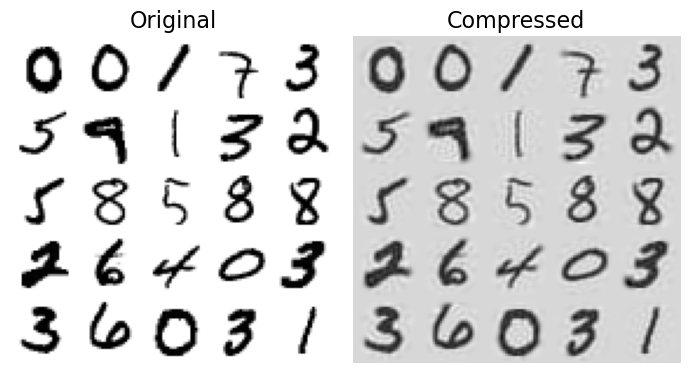

In [36]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [37]:
X_reduced_pca = X_reduced

## Randomized PCA

In [38]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [39]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [40]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

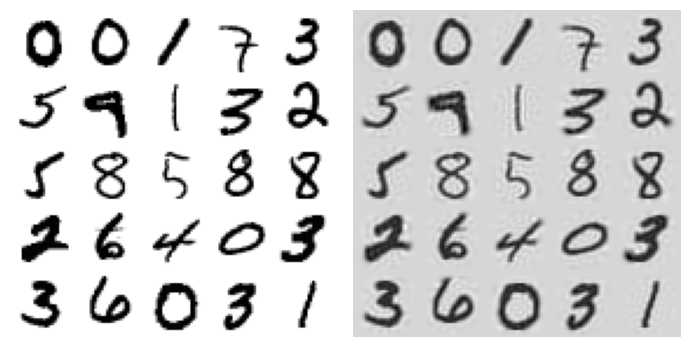

In [41]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [42]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [43]:
np.allclose(pca.mean_, inc_pca.mean_)

True

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [44]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [45]:
del X_mm

Next, another program would load the data and use it for training:

In [46]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**Time complexity:**

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [47]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 24.2 seconds
    Inc PCA: 66.3 seconds
    Rnd PCA: 2.3 seconds
n_components = 10
    PCA: 16.1 seconds
    Inc PCA: 39.0 seconds
    Rnd PCA: 2.6 seconds
n_components = 154
    PCA: 13.5 seconds
    Inc PCA: 42.3 seconds
    Rnd PCA: 8.5 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

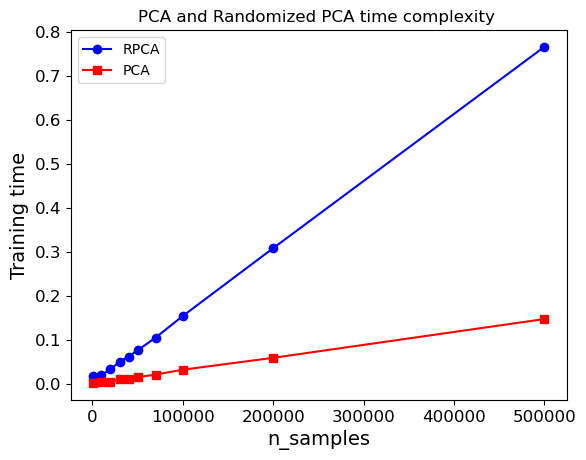

In [48]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

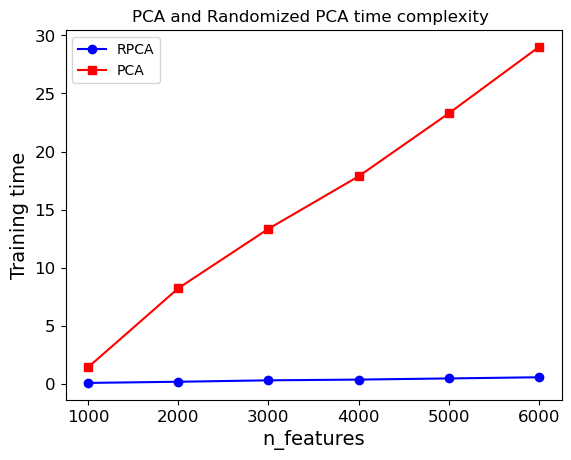

In [49]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [50]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [51]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
C:\Users\JAYASHREE C M\AppData\Local\Temp\ipykernel_7188\3231887444.py:10: SyntaxWarning: invalid escape sequence '\g'
  for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
C:\Users\JAYASHREE C M\AppData\Local\Temp\ipykernel_7188\3231887444.py:10: SyntaxWarning: invalid escape sequence '\g'
  for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):


Saving figure kernel_pca_plot


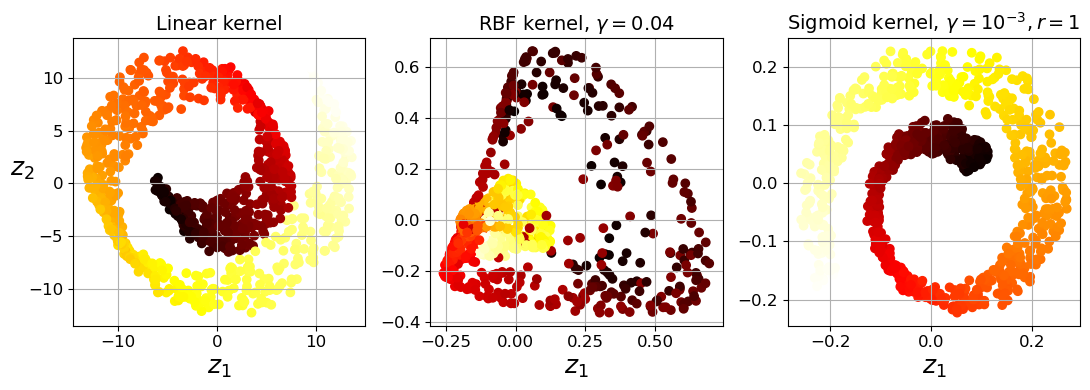

In [52]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

Saving figure preimage_plot


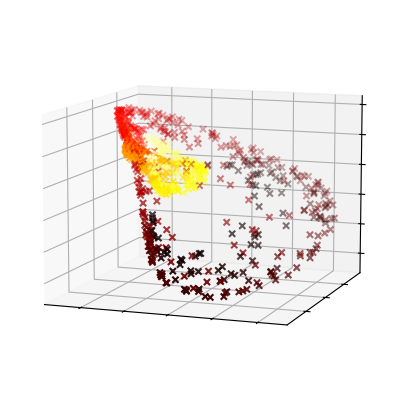

In [53]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

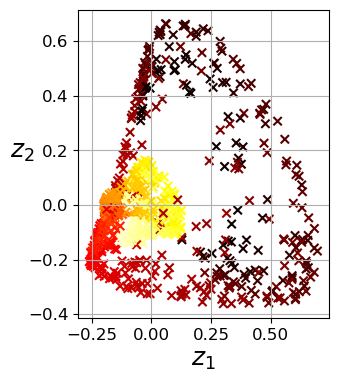

In [54]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Selecting a Kernel and Tuning Hyperparameters

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [56]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [57]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [58]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576613

# LLE

In [59]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [60]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


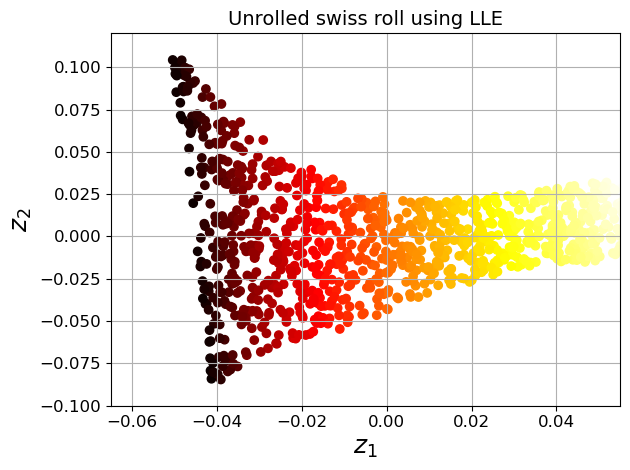

In [61]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## Other Dimensionality Reduction Techniques

In [62]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [63]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [64]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


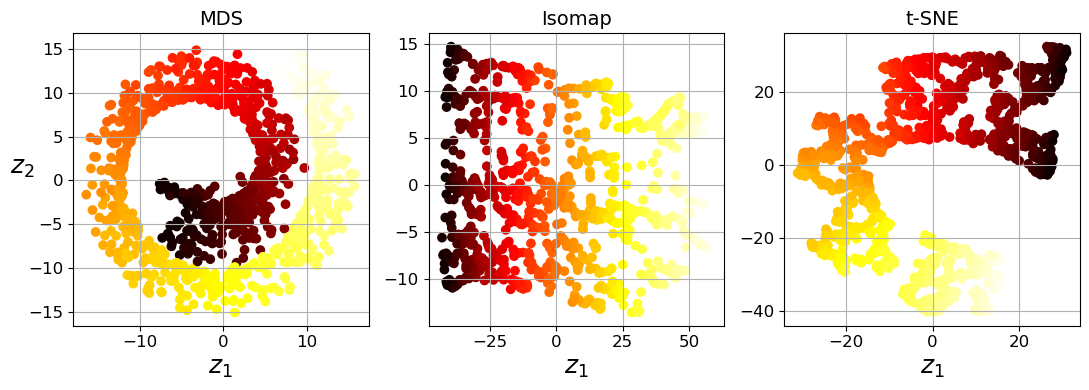

In [66]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Exercises

1. What are the main motivations for reducing a dataset’s dimensionality? What are
the main drawbacks?

Reducing a dataset will normally produce a dataset with a smaller number of variables. This
means that most algorithms that will be learning off of this reduced dataset will do so faster
than the would on the original dataset. The hope is that by reducing dimensions one is
mostly removing noise (and not signal). As the noise is not predictive of anything there is
no need to “keep it arou

If the dimensionality is reduced to 1-d, 2-d, or 3-d then visualizations of the dataset are
possible. This can be a motivation for reducing dimensionality

Drawbacks could include cases where we have removed signal rather than noise and subsequent learning algorithms would then perform worse. In addition, the transformed features
are more difficult to interpret as they are now “blends” of more “base” predictors..nd”.

2. What is the curse of dimensionality?


The curse of dimensionality is the general understanding that increasing the dimension of a
system will not necessarily bring algorithmic improvements. Increasing the dimension of the
features to a machine learning system is problematic in that now each data sample is very
likely to be “very far” from all of the others. Thus as we increase the dimensionality of our
dataset we are simultaneously making it more sparse at a much greater rate.

3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the
operation? If so, how? If not, why?

In general no. If you remove information (even if its noise) it is impossible to “add it back
in” as you don’t have access to it any longer. Some dimensionality reduction algorithms
have a “reverse” method that will give you back a dataset of the same dimension as the
original but some information is lost and not all dimensionality reduction algorithms have
this method.

4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

Yes, PCA can be used to reduce the dimension of any dataset. Whether learning using
the PCA reduced dataset results in performance that is much worse than learning using
the original dataset is problem dependent. The fact that PCA is a linear technique and we
are told to assume that our dataset is highly nonlinear indicates that performance on the
reduced dataset will most likely be worse than on the original dataset especially if we are
using a nonlinear learning technique that can model the nonlinear relationships.

5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained
variance ratio to 95%. How many dimensions will the resulting dataset have

If the variance is distributed uniformly in the 1000 dimensional space (as it would be if
the data was drawn from a 1000 dimensional unit cube) then we would expect to have
1000(0.95) = 950 remaining dimensions after reduction. Most real world datasets that one
would want to learn from have a large degree of “structure” to them so that they are not
just uniformly spaced and reducing the dimension to 95% of the variance should result in
many fewer final dimensions (than 950).

6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA,
or Kernel PCA?

Vanilla PCA is a good technique to try if there are no other constrains on the problem and
should probability be tried first. Other PCA techniques hope to “solve” some of the problems
that you might find with vanilla PCA. For example, incremental PCA is helpful when the
full dataset cannot fit into your machines memory. In that case, incremental PCA will feed
sequential batches of data (that will fit into memory) until the full dataset is proces

If you think you are only looking for the first d principal components (where d ≪ n) then
randomized PCA will use a randomized algorithm to quickly find these. This can be much
faster than using the full SVD algorithm (which computes all of the principle components

At a heuristic level, kernel PCA uses the “kernel trick” to map the original feature space
into an infinite dimensional one which holds nonlinear powers of the features and then
applies PCA in that higher dimensional space. This allows kernel PCA to better deal with
nonlinearity in the dataset).sed.

7. How can you evaluate the performance of a dimensionality reduction algorithm
on your dataset?

If the dimensional reduction technique has an “inverse” method producing points with the
same dimension as the original dataset then one can measure the l1 or the l2 reconstruction
error. Minimizing this error can say to not perform any dimensionality reduction however
(as then the reconstruction error is zero). If the dimensionality reduction technique is used
as a preprocessing technique then it should keep most of the signal and drop some noise.
That means that a learning algorithm trained on the smaller dimensional dataset should
perform almost as well as one trained on the full dataset.


8. Does it make any sense to chain two different dimensionality reduction algo‐
rithms?

If the dataset has a very large feature dimension n a quick dimensionality reduction algorithm
(like using randomized PCA) can produce a much smaller dataset that eliminates many
“noise features”. A slower more computationally intensive algorithm can then be run on
this preprocessed dataset to reduce the dimension further down to only the “informative”
features.


9. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set
and a test set (take the first 60,000 instances for training, and the remaining
10,000 for testing). Train a Random Forest classifier on the dataset and time how
long it takes, then evaluate the resulting model on the test set. Next, use PCA to
reduce the dataset’s dimensionality, with an explained variance ratio of 95%.
Train a new Random Forest classifier on the reduced dataset and see how long it
takes. Was training much faster? Next evaluate the classifier on the test set: how
does it compare to the previous classifier?


In [67]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [68]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [69]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [70]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 74.30s


In [71]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [73]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()